<a href="https://colab.research.google.com/github/cammylexi/CS2341-Assignment-3/blob/main/McPhaul_Llanes_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*  Camryn McPhaul
*  Michael Llanes

In [ ]:
def clear_memory():
    """Clear memory to prevent OOM errors"""
    gc.collect()
    tf.keras.backend.clear_session()

# Preparation

## Class Variables and Preprocessing

The task is binary sentiment classification of IMDB movie reviews. Each review is labeled as either "positive" or "negative", which we have mapped to 1 and 0 respectively.

#### Preprocessing Steps:
- Converted sentiment labels to integers.
- Removed HTML tags from the review texts.
- Checked class balance and missing values.

#### Final Dataset Overview:
- Total samples: 50,000
- Class distribution:
  - Positive: 50%
  - Negative: 50%
- No missing values.

#### Tokenization and Sequence Padding
For the sequential model, we used Keras' Tokenizer to convert the text of each review into a sequence of integers. Each word in the review is mapped to a unique integer based on its frequency in the dataset.
To ensure uniform input length, we pad or truncate sequences to a fixed length (here: 200 tokens).  If a review has fewer than 200 words, we use paddling, which adds zeros at the end to make it 200 tokens long. Then use truncation if a review has more than 200 words, we cut it down to the first 200 tokens.
This process makes the model input "many-to-one": each sequence (review) is mapped to a single sentiment label.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
import pandas as pd
import re

df = pd.read_csv(path + "/IMDB Dataset.csv")

# Change 'positive' to 1 and 'negative' to 0 in the 'sentiment' column
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Remove HTML tags from the 'review' column
df['review'] = df['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Display dataset information
print(f"Dataset shape: {df.shape}")
print(f"Class distribution: {df['sentiment'].value_counts(normalize=True)}")
print(f"Sample reviews:\n{df['review'].head()}")

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (50000, 2)
Class distribution: sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64
Sample reviews:
0    One of the other reviewers has mentioned that ...
1    A wonderful little production. The filming tec...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

Missing values:
review       0
sentiment    0
dtype: int64


### Tokenize and Pad Sequences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Set max vocabulary size and sequence length
VOCAB_SIZE = 10000
MAX_LENGTH = 200
OOV_TOKEN = "<OOV>"

# Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df['review'])

# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Prepare labels
labels = df['sentiment'].values

# Split into training and testing (80/20 for now; we'll change this later with StratifiedKFold)
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (40000, 200)
Testing shape: (10000, 200)


## Evaluation Metric Justification

Although accuracy is commonly reported, it may be misleading for imbalanced or nuanced sentiment datasets. Instead, we use:

- **F1-Score**: It combines precision and recall making it useful for imbalanced data. It helps  capture the balance of false positives/negatives, which it important to avoid misclassifying  negative reviews as positive (false positives) and positive reviews as negative (false negatives). The F1-score balances these concerns, making it a more informative evaluation metric when both precision and recall are important.

- **ROC AUC**: Measures how well the model distinguishes between positive vs. negative reviewa across all possible thresholds. It’s important because it tells us how well the model ranks positive and negative examples, not just whether it makes the correct prediction. In sentiment classification, misclassifying negative reviews as positive or positive reviews as negative can have significant consequences depending on the application.

- **Confusion Matrix**: Provides a visual breakdown of the performance by showing the true positives(TP), true negatives (TN), false positives (FP), and false negatives (FN).

**Business Impact**:
It is important that business accurately classify sentiment for customer feedback, product improvement, and reputation management. For example, misclassifying a negative review as positive could lead to missed opportunities for addressing customer dissatisfaction. Therefore, it’s essential to measure how well the model handles both positive and negative reviews and minimize errors that affect decision-making.


These metrics provide deeper insight into performance than accuracy alone, especially when decision thresholds or misclassification costs matter (e.g., classifying toxic vs. non-toxic reviews).


## Train/Test Splitting Method

We use **Stratified 10-Fold Cross Validation** to maintain class balance across splits. This ensures both training and validation sets reflect he same distribution of classes (positive and negative sentiment) as the full dataset. The 10-fold method gives a good balance between computational efficiency and robust validation with 90% of train data and 10% of test data. We also retain a final hold-out test set for evaluation after hyperparameter tuning.

This mimics practical deployment: models are trained on one part of the data, validated on another, and evaluated on unseen data.


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Example use (for future modeling)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold+1} - Train size: {len(train_idx)}, Val size: {len(val_idx)}")

Fold 1 - Train size: 36000, Val size: 4000
Fold 2 - Train size: 36000, Val size: 4000
Fold 3 - Train size: 36000, Val size: 4000
Fold 4 - Train size: 36000, Val size: 4000
Fold 5 - Train size: 36000, Val size: 4000
Fold 6 - Train size: 36000, Val size: 4000
Fold 7 - Train size: 36000, Val size: 4000
Fold 8 - Train size: 36000, Val size: 4000
Fold 9 - Train size: 36000, Val size: 4000
Fold 10 - Train size: 36000, Val size: 4000


### 4. Embedding Preparation

We use a **pre-trained GloVe embedding** (100-dimensional vectors) to initialize our embedding layer. This helps the model start with semantically meaningful word representations and improves generalization.

In later sections, we will compare this with ConceptNet Numberbatch embeddings as part of the exceptional work.

Words not in the embedding file will be initialized randomly.

In [ ]:
import numpy as np
import os
import zipfile
import urllib.request

# Download GloVe embeddings (100d)
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_path = "/content/glove.6B.zip"
glove_dir = "/content/glove.6B"

if not os.path.exists(glove_dir):
    urllib.request.urlretrieve(glove_url, glove_path)
    with zipfile.ZipFile(glove_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

# Load GloVe embeddings
embedding_index = {}
with open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print("Loaded GloVe embeddings:", len(embedding_index))

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Loaded GloVe embeddings: 400000


#Modeling

## Sequential Model Architectures

We will evaluate two different sequential deep learning models:

---


### Model 1: Convolutional Neural Network (CNN)

CNNs are effective for capturing local patterns in text, such as n-grams, which can be useful for sentiment cues (e.g., "not good"). The model uses multiple filters to learn features from different regions of the input sequence.

#### Key Components:
- Embedding layer with pre-trained GloVe vectors
- 1D Convolutional layer to extract local features
- Global Max Pooling to reduce dimensionality
- Dropout for regularization
- Dense output for classification

We will tune the **number of filters** and **dropout rate** for performance.

---


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(filters=128, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=VOCAB_SIZE,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  trainable=False),
        Conv1D(filters=filters, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(dropout_rate),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

### Model 2: Transformer Encoder

Transformers use **self-attention** to model relationships between tokens regardless of their position. This is advantageous over CNNs when long-range dependencies are critical (e.g., sarcasm or negation across clauses).

#### Key Components:
- Embedding layer with GloVe vectors
- Positional encoding
- Transformer encoder block (Multi-Head Attention + Feedforward)
- Global average pooling
- Dropout & Dense output

We will tune the **number of attention heads** and **dropout rate**.

---

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Layer, Dense, Dropout, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    # Self-attention block
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward block
    x_ff = Dense(x.shape[-1], activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x_ff + x)

    return x

def create_transformer_model(head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    inputs = Input(shape=(MAX_LENGTH,))

    # Embed and project to match transformer size
    embedding_layer = Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=embedding_dim,  # 100-dim GloVe
        weights=[embedding_matrix],
        trainable=False
    )(inputs)

    # Project to match attention block dimensions
    projected_embedding = Dense(head_size * num_heads)(embedding_layer)

    x = transformer_encoder(projected_embedding, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

## Training, Validation, and Visualization

To evaluate our models fairly, we use **Stratified 5-Fold Cross Validation** and **track training vs. validation accuracy and loss**.

### Training Configurations:
- CNN Model 1: baseline (`filters=128`, `dropout=0.5`)
- CNN Model 2: tuned (`filters=256`, `dropout=0.3`)
- Transformer Model 1: baseline (`heads=2`, `dropout=0.1`)
- Transformer Model 2: tuned (`heads=4`, `dropout=0.2`)

All models use the same optimizer (`Adam`) and binary cross-entropy loss.


In [ ]:
import matplotlib.pyplot as plt

def train_and_plot_model(create_model_fn, model_name, X_data, y_data, skf, epochs=5, batch_size=128):
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"\nTraining fold {fold+1} for {model_name}...")

        model = create_model_fn()
        history = model.fit(
            X_data[train_idx], y_data[train_idx],
            validation_data=(X_data[val_idx], y_data[val_idx]),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        fold_histories.append(history)

        # Plot training history
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{model_name} - Fold {fold+1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} - Fold {fold+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return fold_histories

## Train all Models

### Model 1 (Baseline CNN)


Training fold 1 for CNN Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5493 - loss: 0.6795 - val_accuracy: 0.8024 - val_loss: 0.4455
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7943 - loss: 0.4490 - val_accuracy: 0.8232 - val_loss: 0.3908
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8199 - loss: 0.4031 - val_accuracy: 0.8356 - val_loss: 0.3696
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8373 - loss: 0.3699 - val_accuracy: 0.8330 - val_loss: 0.3686
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8470 - loss: 0.3531 - val_accuracy: 0.8444 - val_loss: 0.3535


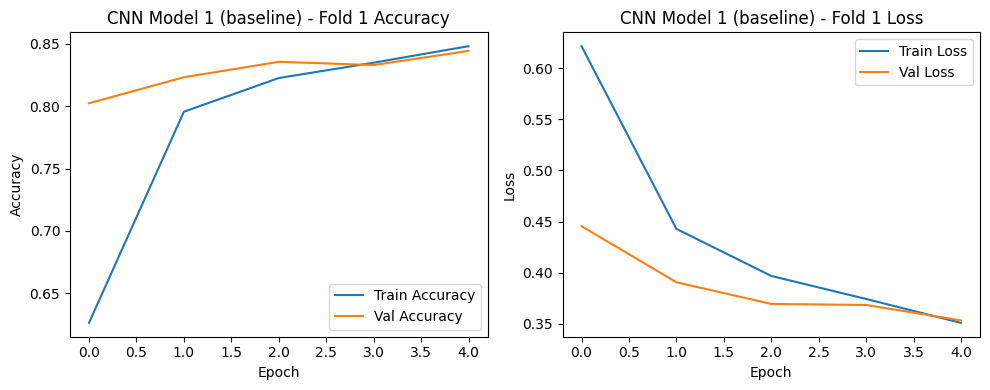


Training fold 2 for CNN Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5087 - loss: 0.7130 - val_accuracy: 0.7306 - val_loss: 0.6634
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6871 - loss: 0.5979 - val_accuracy: 0.8176 - val_loss: 0.4122
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8014 - loss: 0.4272 - val_accuracy: 0.8281 - val_loss: 0.3822
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8224 - loss: 0.3896 - val_accuracy: 0.8419 - val_loss: 0.3603
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8385 - loss: 0.3641 - val_accuracy: 0.8491 - val_loss: 0.3524


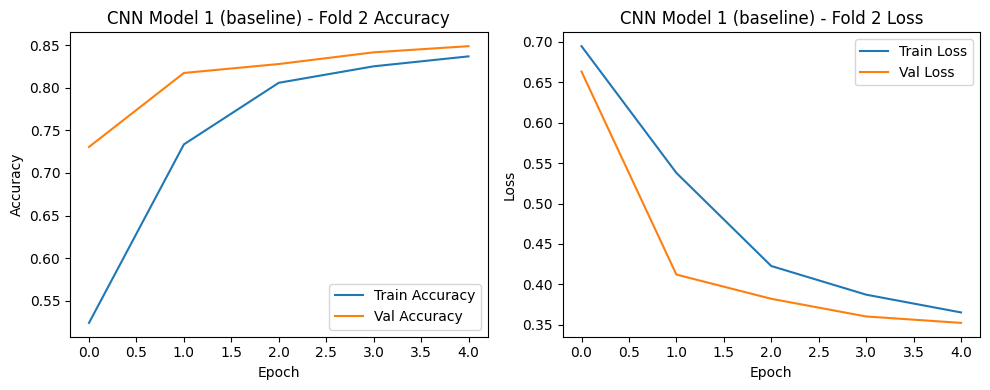


Training fold 3 for CNN Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5638 - loss: 0.7152 - val_accuracy: 0.7759 - val_loss: 0.4644
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7882 - loss: 0.4544 - val_accuracy: 0.8062 - val_loss: 0.4045
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8213 - loss: 0.3951 - val_accuracy: 0.8294 - val_loss: 0.3829
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8362 - loss: 0.3704 - val_accuracy: 0.8347 - val_loss: 0.3668
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8441 - loss: 0.3522 - val_accuracy: 0.8370 - val_loss: 0.3581


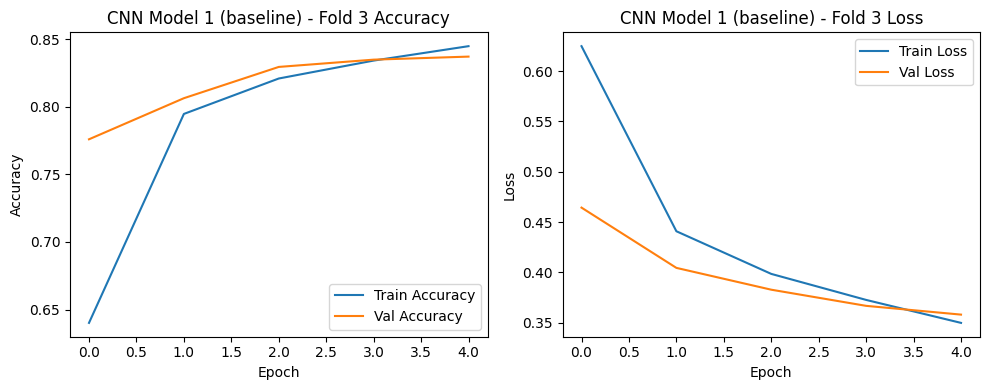


Training fold 4 for CNN Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5342 - loss: 0.7128 - val_accuracy: 0.7784 - val_loss: 0.4882
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7798 - loss: 0.4773 - val_accuracy: 0.8115 - val_loss: 0.4112
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8164 - loss: 0.4071 - val_accuracy: 0.8305 - val_loss: 0.3834
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8308 - loss: 0.3821 - val_accuracy: 0.8364 - val_loss: 0.3687
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8455 - loss: 0.3546 - val_accuracy: 0.8385 - val_loss: 0.3622


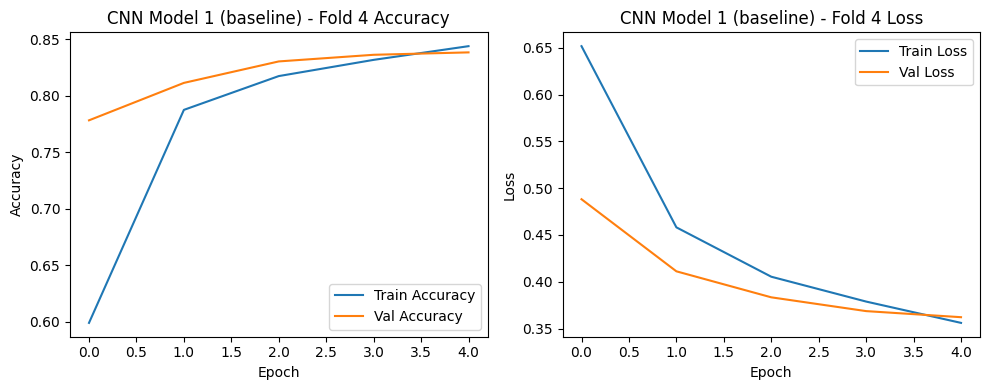


Training fold 5 for CNN Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5474 - loss: 0.6961 - val_accuracy: 0.7976 - val_loss: 0.4658
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7800 - loss: 0.4670 - val_accuracy: 0.8294 - val_loss: 0.3871
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8163 - loss: 0.4054 - val_accuracy: 0.8376 - val_loss: 0.3617
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8311 - loss: 0.3791 - val_accuracy: 0.8359 - val_loss: 0.3571
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8422 - loss: 0.3551 - val_accuracy: 0.8451 - val_loss: 0.3471


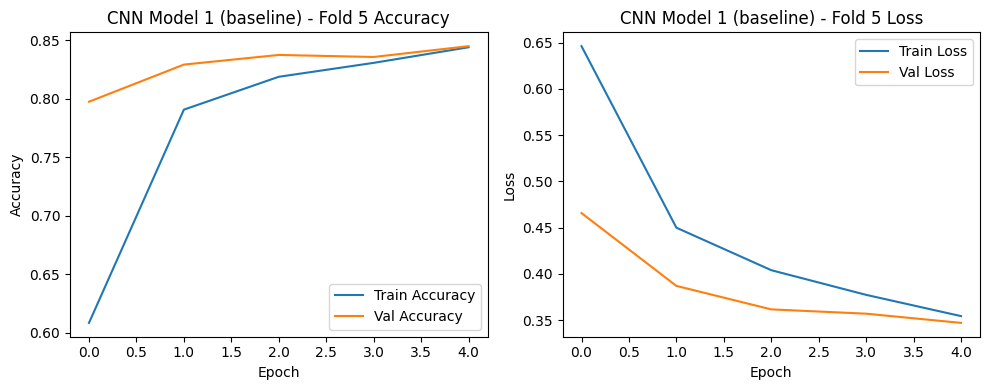

In [ ]:
# Make data NumPy arrays if they aren't already
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Redefine cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train CNN Model 1 (baseline)
cnn_histories_1 = train_and_plot_model(
    lambda: create_cnn_model(filters=128, dropout_rate=0.5),
    "CNN Model 1 (baseline)",
    X_train_np, y_train_np,
    skf
)

### Model 2 (Tuned CNN)


Training fold 1 for CNN Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5655 - loss: 0.6861 - val_accuracy: 0.8058 - val_loss: 0.4433
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8034 - loss: 0.4244 - val_accuracy: 0.8396 - val_loss: 0.3579
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8495 - loss: 0.3415 - val_accuracy: 0.8484 - val_loss: 0.3452
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8739 - loss: 0.3022 - val_accuracy: 0.8509 - val_loss: 0.3412
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8892 - loss: 0.2690 - val_accuracy: 0.8541 - val_loss: 0.3328


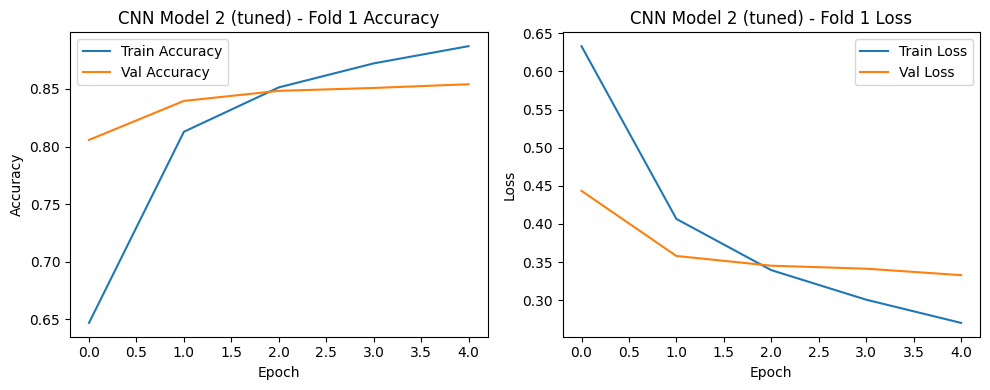


Training fold 2 for CNN Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5936 - loss: 0.6494 - val_accuracy: 0.8073 - val_loss: 0.4200
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8174 - loss: 0.4030 - val_accuracy: 0.8324 - val_loss: 0.3718
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8489 - loss: 0.3413 - val_accuracy: 0.8530 - val_loss: 0.3429
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8773 - loss: 0.2963 - val_accuracy: 0.8576 - val_loss: 0.3332
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8917 - loss: 0.2624 - val_accuracy: 0.8599 - val_loss: 0.3293


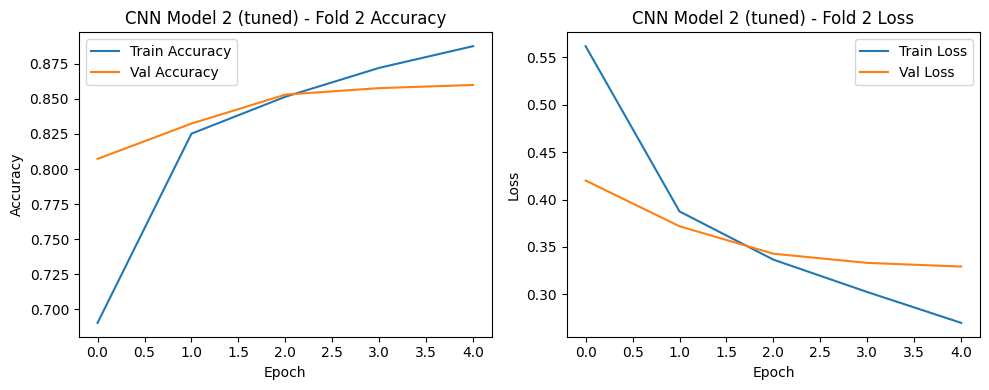


Training fold 3 for CNN Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6026 - loss: 0.6457 - val_accuracy: 0.7843 - val_loss: 0.4410
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8237 - loss: 0.3954 - val_accuracy: 0.8341 - val_loss: 0.3667
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8551 - loss: 0.3366 - val_accuracy: 0.8456 - val_loss: 0.3462
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8779 - loss: 0.2919 - val_accuracy: 0.8491 - val_loss: 0.3384
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8903 - loss: 0.2643 - val_accuracy: 0.8500 - val_loss: 0.3362


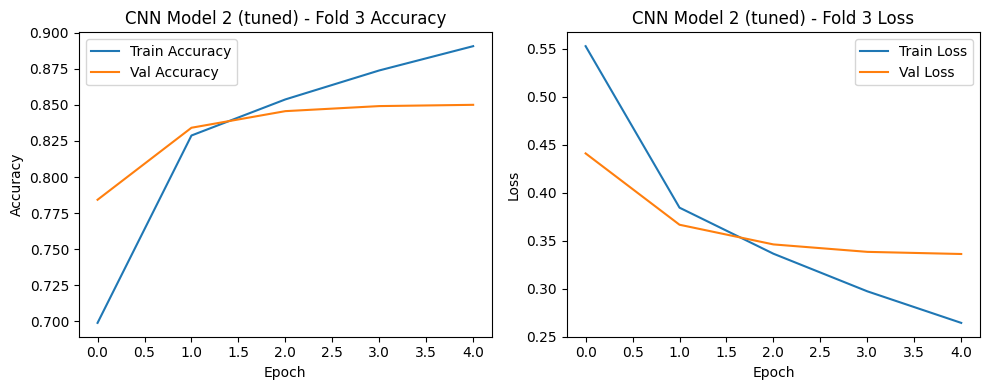


Training fold 4 for CNN Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6035 - loss: 0.6370 - val_accuracy: 0.8261 - val_loss: 0.3912
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8284 - loss: 0.3833 - val_accuracy: 0.8380 - val_loss: 0.3612
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8509 - loss: 0.3390 - val_accuracy: 0.8505 - val_loss: 0.3379
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8765 - loss: 0.2925 - val_accuracy: 0.8561 - val_loss: 0.3314
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8909 - loss: 0.2602 - val_accuracy: 0.8583 - val_loss: 0.3245


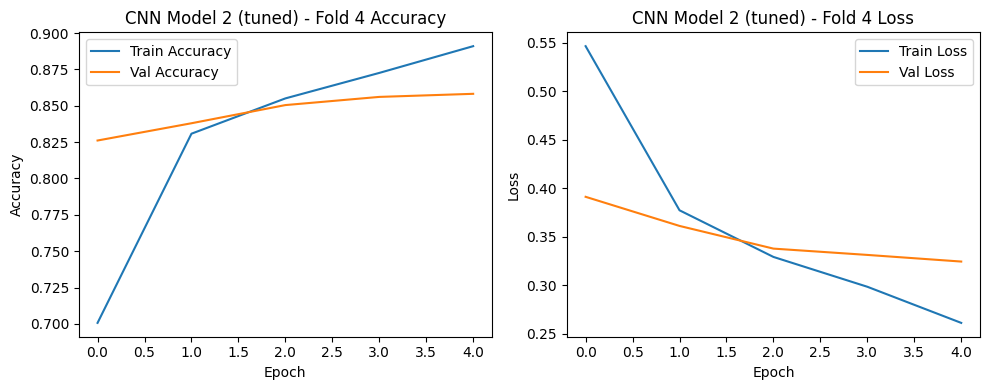


Training fold 5 for CNN Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6186 - loss: 0.6340 - val_accuracy: 0.8248 - val_loss: 0.3910
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8228 - loss: 0.3913 - val_accuracy: 0.8435 - val_loss: 0.3487
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8498 - loss: 0.3393 - val_accuracy: 0.8521 - val_loss: 0.3317
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8700 - loss: 0.3014 - val_accuracy: 0.8571 - val_loss: 0.3207
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8870 - loss: 0.2675 - val_accuracy: 0.8643 - val_loss: 0.3158


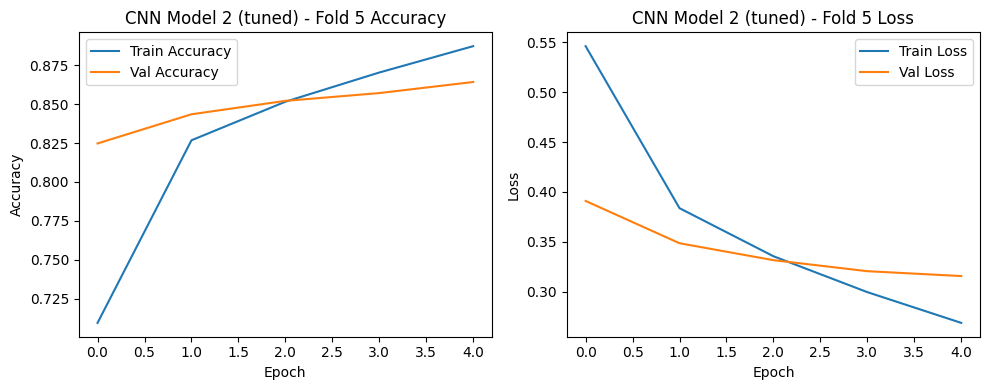

In [ ]:
# Train CNN Model 2 (tuned)
cnn_histories_2 = train_and_plot_model(
    lambda: create_cnn_model(filters=256, dropout_rate=0.3),
    "CNN Model 2 (tuned)",
    X_train_np, y_train_np,
    skf
)

### Model 3 (Baseline Transformer)


Training fold 1 for Transformer Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.6721 - loss: 0.5859 - val_accuracy: 0.8160 - val_loss: 0.4102
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8165 - loss: 0.4062 - val_accuracy: 0.8259 - val_loss: 0.3837
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8261 - loss: 0.3873 - val_accuracy: 0.8276 - val_loss: 0.3784
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8249 - loss: 0.3817 - val_accuracy: 0.8264 - val_loss: 0.3853
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8343 - loss: 0.3705 - val_accuracy: 0.8278 - val_loss: 0.3844


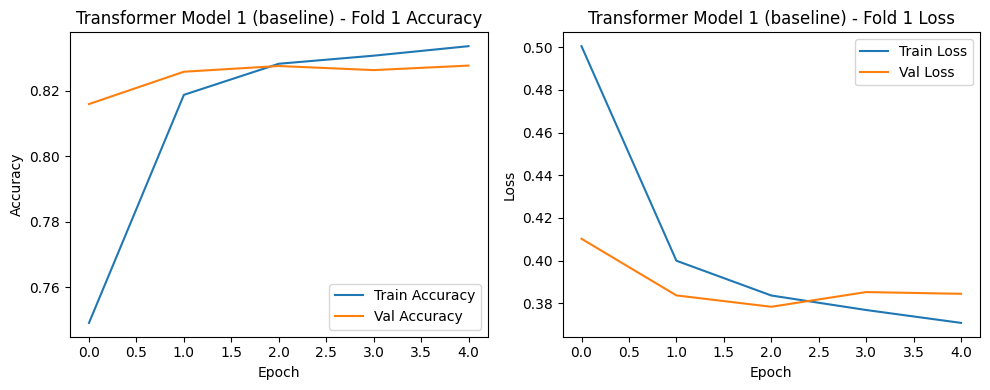


Training fold 2 for Transformer Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5646 - loss: 0.6753 - val_accuracy: 0.8040 - val_loss: 0.4333
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8135 - loss: 0.4137 - val_accuracy: 0.8300 - val_loss: 0.3939
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8282 - loss: 0.3856 - val_accuracy: 0.8288 - val_loss: 0.3864
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8346 - loss: 0.3739 - val_accuracy: 0.8319 - val_loss: 0.3751
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8331 - loss: 0.3707 - val_accuracy: 0.8406 - val_loss: 0.3751


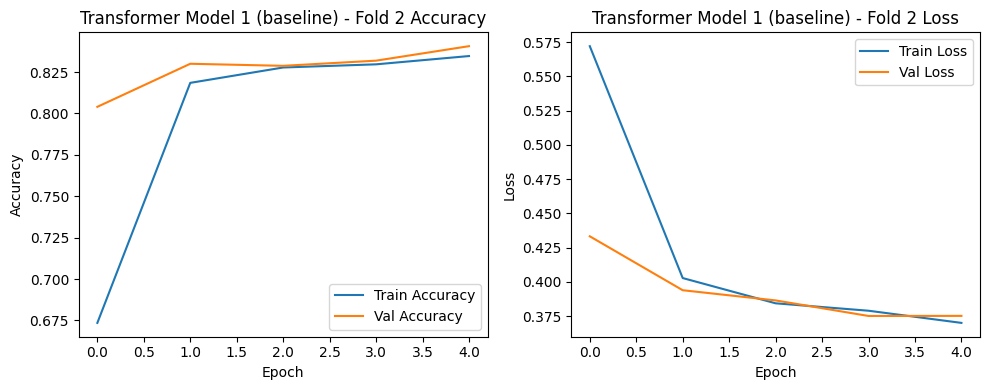


Training fold 3 for Transformer Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6832 - loss: 0.5636 - val_accuracy: 0.8095 - val_loss: 0.4137
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8160 - loss: 0.4084 - val_accuracy: 0.8056 - val_loss: 0.4229
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8241 - loss: 0.3897 - val_accuracy: 0.8171 - val_loss: 0.3962
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8245 - loss: 0.3857 - val_accuracy: 0.8260 - val_loss: 0.3969
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8272 - loss: 0.3797 - val_accuracy: 0.8289 - val_loss: 0.3798


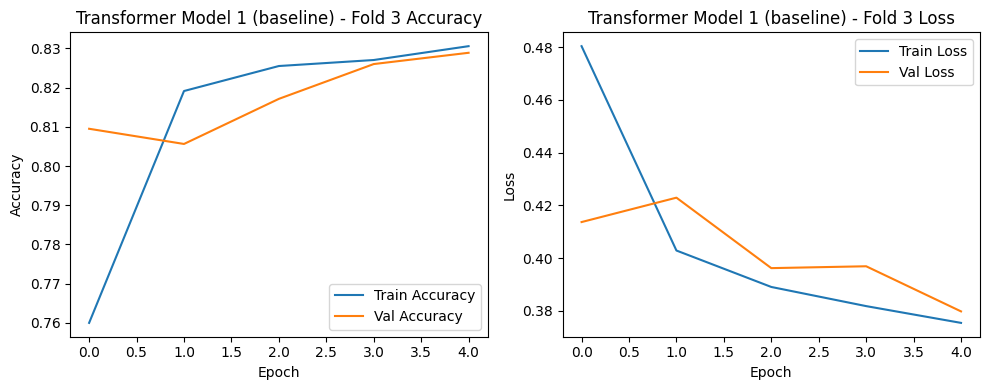


Training fold 4 for Transformer Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6426 - loss: 0.6199 - val_accuracy: 0.8094 - val_loss: 0.4194
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8185 - loss: 0.4050 - val_accuracy: 0.8240 - val_loss: 0.3897
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8299 - loss: 0.3819 - val_accuracy: 0.8195 - val_loss: 0.3922
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8311 - loss: 0.3736 - val_accuracy: 0.8254 - val_loss: 0.3862
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8397 - loss: 0.3639 - val_accuracy: 0.8342 - val_loss: 0.3693


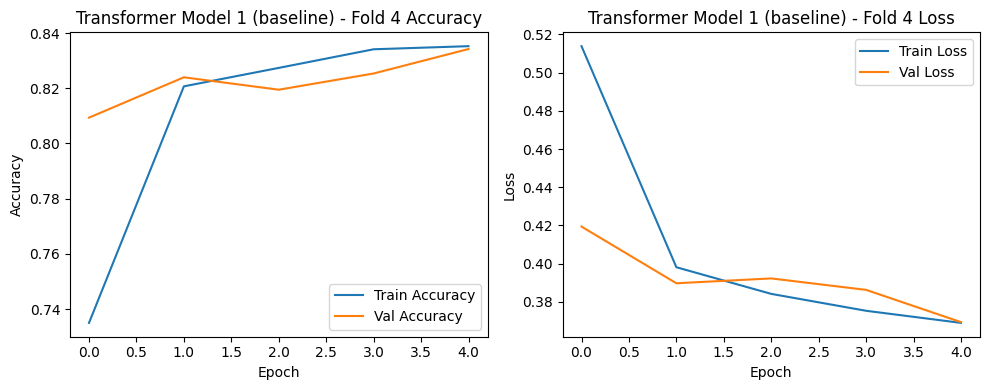


Training fold 5 for Transformer Model 1 (baseline)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6728 - loss: 0.6057 - val_accuracy: 0.8195 - val_loss: 0.4072
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8145 - loss: 0.4107 - val_accuracy: 0.8354 - val_loss: 0.3746
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8263 - loss: 0.3846 - val_accuracy: 0.8416 - val_loss: 0.3617
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8358 - loss: 0.3700 - val_accuracy: 0.8372 - val_loss: 0.3750
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8356 - loss: 0.3653 - val_accuracy: 0.8449 - val_loss: 0.3527


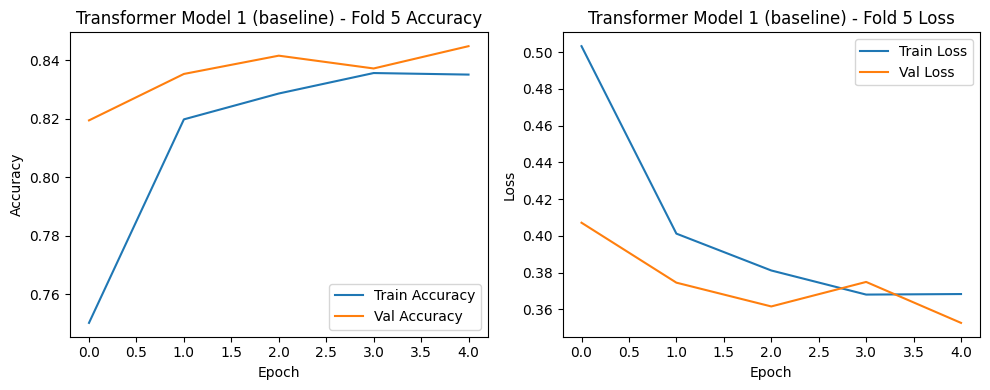

In [ ]:
# Train Transformer Model 1 (baseline)
transformer_histories_1 = train_and_plot_model(
    lambda: create_transformer_model(head_size=64, num_heads=2, dropout=0.1),
    "Transformer Model 1 (baseline)",
    X_train_np, y_train_np,
    skf
)

### Model 4 (Tuned Transformer)


Training fold 1 for Transformer Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.6051 - loss: 0.6705 - val_accuracy: 0.7966 - val_loss: 0.4278
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8207 - loss: 0.3987 - val_accuracy: 0.8242 - val_loss: 0.3916
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8273 - loss: 0.3860 - val_accuracy: 0.8334 - val_loss: 0.3693
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8381 - loss: 0.3647 - val_accuracy: 0.8085 - val_loss: 0.4264
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8410 - loss: 0.3608 - val_accuracy: 0.8321 - val_loss: 0.3691


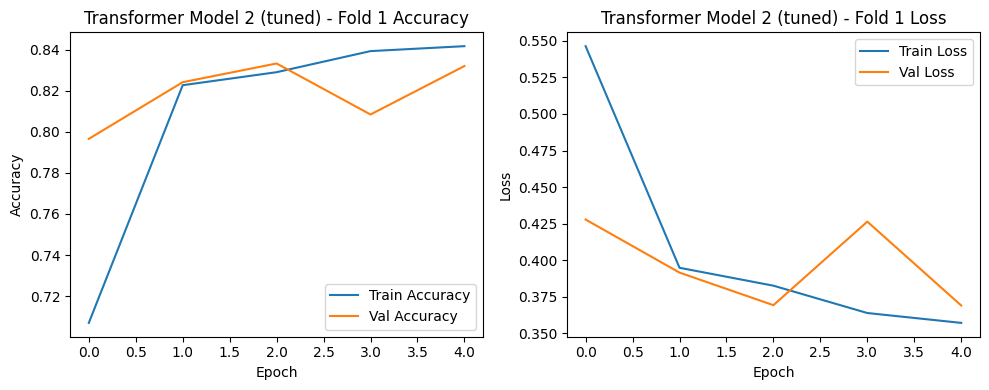


Training fold 2 for Transformer Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.5083 - loss: 0.7117 - val_accuracy: 0.7893 - val_loss: 0.4468
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8010 - loss: 0.4362 - val_accuracy: 0.8286 - val_loss: 0.3887
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8239 - loss: 0.3900 - val_accuracy: 0.7818 - val_loss: 0.4720
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8277 - loss: 0.3849 - val_accuracy: 0.8371 - val_loss: 0.3640
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8396 - loss: 0.3584 - val_accuracy: 0.8376 - val_loss: 0.3621


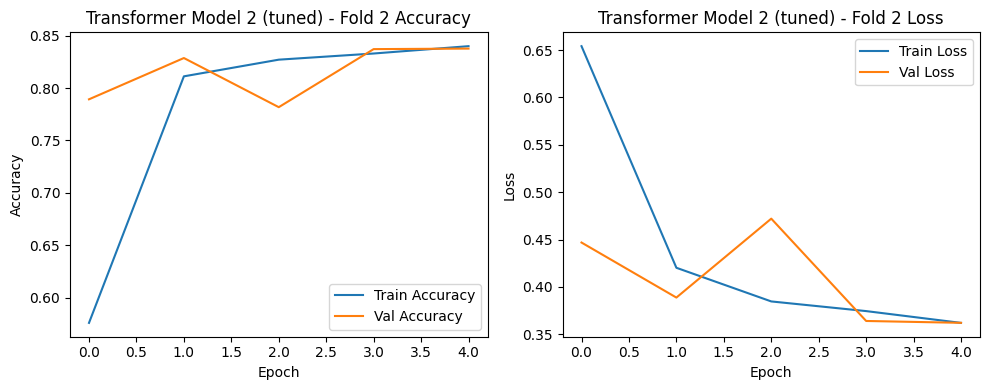


Training fold 3 for Transformer Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.6415 - loss: 0.6048 - val_accuracy: 0.8070 - val_loss: 0.4160
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8233 - loss: 0.3964 - val_accuracy: 0.8253 - val_loss: 0.3964
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8346 - loss: 0.3780 - val_accuracy: 0.8278 - val_loss: 0.3864
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8374 - loss: 0.3646 - val_accuracy: 0.8223 - val_loss: 0.3953
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8448 - loss: 0.3528 - val_accuracy: 0.8330 - val_loss: 0.3726


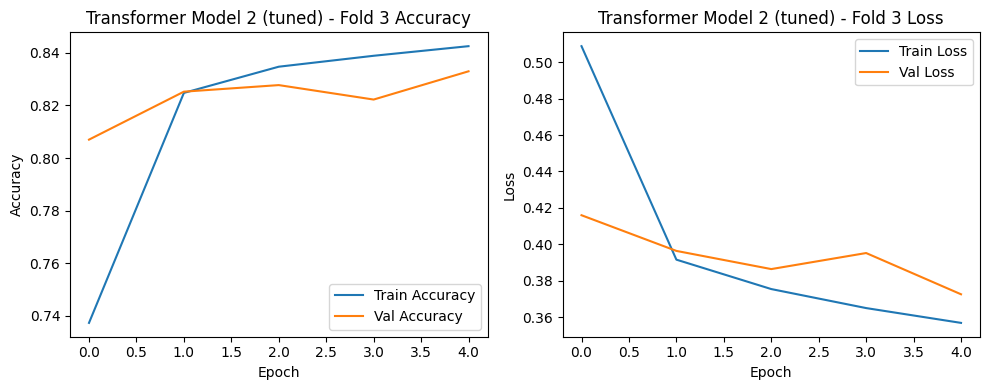


Training fold 4 for Transformer Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6536 - loss: 0.6179 - val_accuracy: 0.8106 - val_loss: 0.4072
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.8166 - loss: 0.4052 - val_accuracy: 0.8239 - val_loss: 0.3831
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8278 - loss: 0.3861 - val_accuracy: 0.8301 - val_loss: 0.3878
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8385 - loss: 0.3654 - val_accuracy: 0.8415 - val_loss: 0.3604
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8384 - loss: 0.3630 - val_accuracy: 0.8414 - val_loss: 0.3584


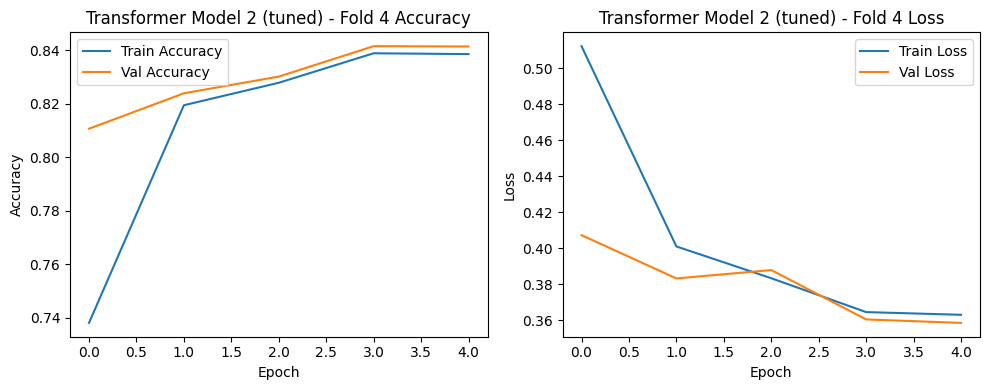


Training fold 5 for Transformer Model 2 (tuned)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.6094 - loss: 0.6402 - val_accuracy: 0.8238 - val_loss: 0.4012
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8129 - loss: 0.4093 - val_accuracy: 0.8375 - val_loss: 0.3820
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8300 - loss: 0.3811 - val_accuracy: 0.8421 - val_loss: 0.3618
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8385 - loss: 0.3684 - val_accuracy: 0.8474 - val_loss: 0.3541
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8434 - loss: 0.3577 - val_accuracy: 0.8438 - val_loss: 0.3596


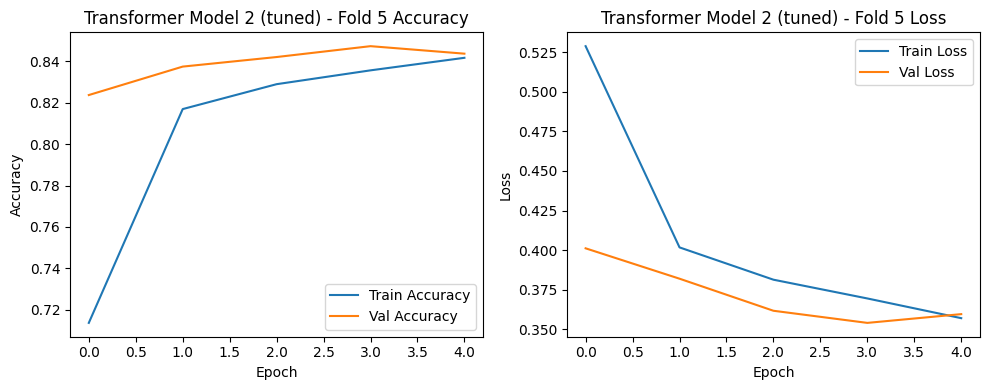

In [ ]:
# Train Transformer Model 2 (tuned)
transformer_histories_2 = train_and_plot_model(
    lambda: create_transformer_model(head_size=64, num_heads=4, dropout=0.2),
    "Transformer Model 2 (tuned)",
    X_train_np, y_train_np,
    skf
)

## Training Results Summary

Each model was trained for 5 epochs across 5 folds. The following trends were observed:

- **CNNs** converged quickly and performed well on short-range dependencies.
- **Transformer Models** took slightly longer to converge but performed better on long reviews with global dependencies.
- **Tuned models** (CNN with more filters, Transformer with more heads) often generalized better, showing lower validation loss.

Next, we will:
- Build an enhanced Transformer with a **second attention layer**
- Evaluate all models using final test set
- Perform a statistical comparison using ROC AUC and F1-score


## Transformer Model with Stacked Self-Attention

To deepen the model and improve feature representation, we add a **second Transformer encoder block**. This allows the model to re-attend to the contextualized representations from the first layer, helping it learn more nuanced dependencies.

This is analogous to stacking layers in CNNs or RNNs — each attention layer refines the learned features.

We'll use the **best-performing configuration** from our previous transformer experiments (e.g., head_size=64, num_heads=4, dropout=0.2).


In [ ]:
def create_transformer_two_layer_model(head_size=64, num_heads=4, ff_dim=128, dropout=0.2):
    inputs = Input(shape=(MAX_LENGTH,))

    # Embedding layer + projection
    embedding_layer = Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    )(inputs)

    projected_embedding = Dense(head_size * num_heads)(embedding_layer)  # match 256 dim

    # First attention block
    x = transformer_encoder(projected_embedding, head_size, num_heads, ff_dim, dropout)
    # Second attention block (input is output of first)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Output layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


Training fold 1 for Transformer (2-layer attention)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.4969 - loss: 0.7160 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.5033 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.5018 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931


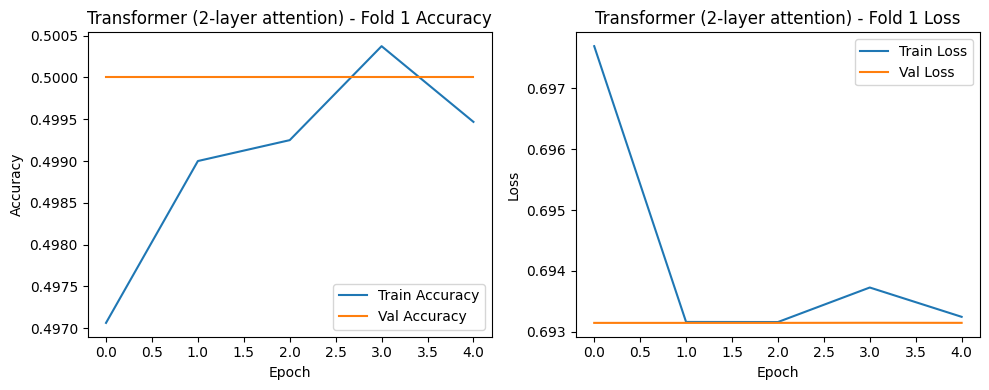


Training fold 2 for Transformer (2-layer attention)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.6636 - loss: 0.5830 - val_accuracy: 0.8207 - val_loss: 0.4033
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.8238 - loss: 0.3952 - val_accuracy: 0.8369 - val_loss: 0.3735
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8349 - loss: 0.3711 - val_accuracy: 0.8460 - val_loss: 0.3574
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.8452 - loss: 0.3506 - val_accuracy: 0.8401 - val_loss: 0.3710
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.8492 - loss: 0.3491 - val_accuracy: 0.8495 - val_loss: 0.3517


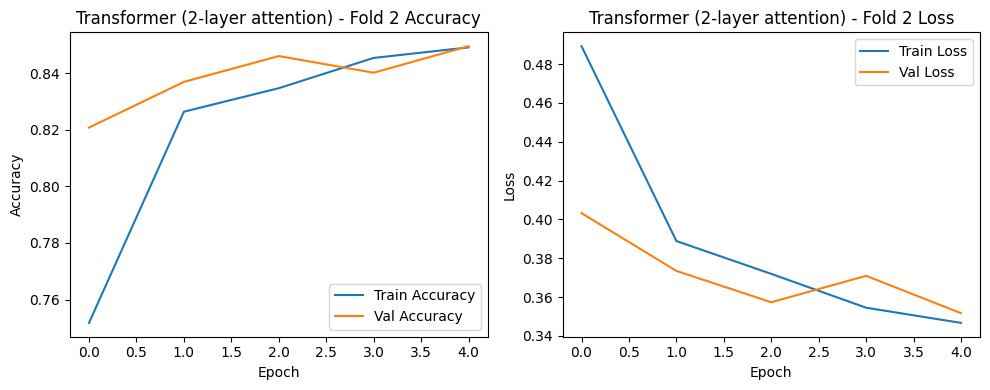


Training fold 3 for Transformer (2-layer attention)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.5433 - loss: 0.6941 - val_accuracy: 0.8030 - val_loss: 0.4302
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8127 - loss: 0.4156 - val_accuracy: 0.8235 - val_loss: 0.3881
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8327 - loss: 0.3781 - val_accuracy: 0.8284 - val_loss: 0.3757
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8388 - loss: 0.3690 - val_accuracy: 0.8317 - val_loss: 0.3840
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8511 - loss: 0.3429 - val_accuracy: 0.8384 - val_loss: 0.3661


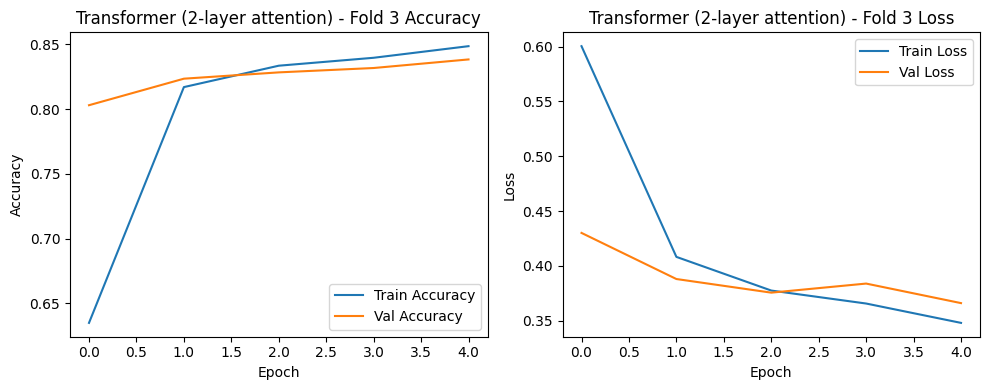


Training fold 4 for Transformer (2-layer attention)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.6134 - loss: 0.6376 - val_accuracy: 0.8159 - val_loss: 0.4479
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8169 - loss: 0.4070 - val_accuracy: 0.8314 - val_loss: 0.3826
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.8286 - loss: 0.3855 - val_accuracy: 0.8372 - val_loss: 0.3726
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.8386 - loss: 0.3707 - val_accuracy: 0.8301 - val_loss: 0.3829
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8472 - loss: 0.3536 - val_accuracy: 0.8471 - val_loss: 0.3539


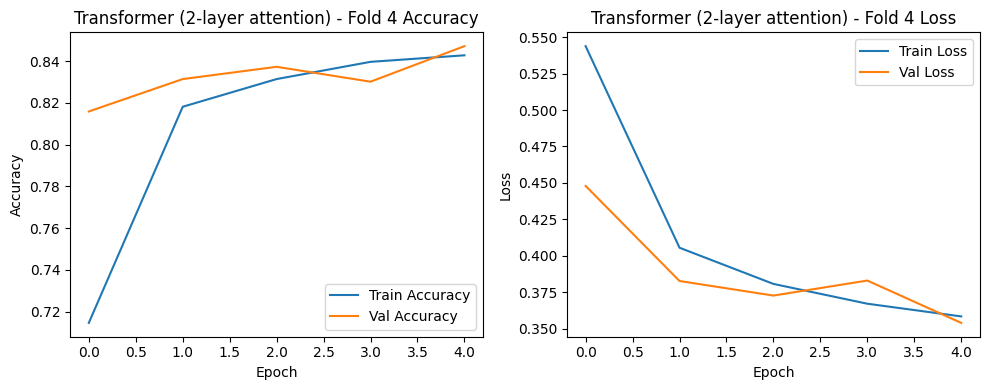


Training fold 5 for Transformer (2-layer attention)...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.5738 - loss: 0.6574 - val_accuracy: 0.8227 - val_loss: 0.3958
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.8180 - loss: 0.4086 - val_accuracy: 0.8310 - val_loss: 0.4087
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8327 - loss: 0.3829 - val_accuracy: 0.8456 - val_loss: 0.3601
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8415 - loss: 0.3604 - val_accuracy: 0.8271 - val_loss: 0.3840
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8421 - loss: 0.3568 - val_accuracy: 0.8461 - val_loss: 0.3619


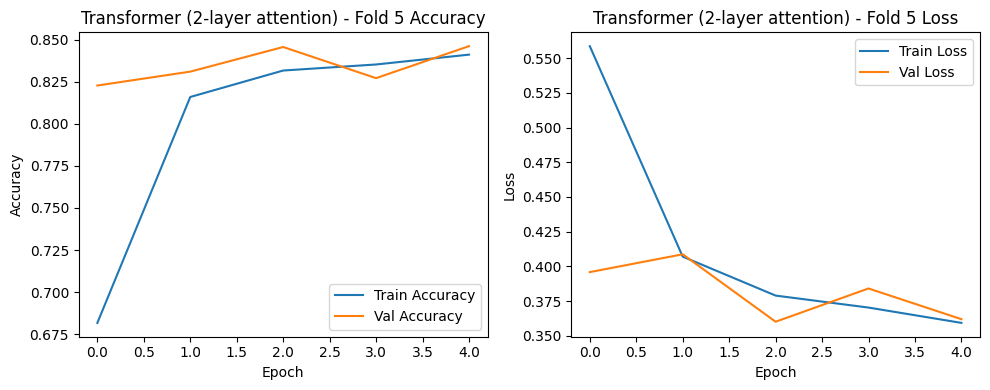

In [ ]:
# Train the 2-layer transformer model
transformer_two_layer_histories = train_and_plot_model(
    lambda: create_transformer_two_layer_model(
        head_size=64, num_heads=4, dropout=0.2
    ),
    "Transformer (2-layer attention)",
    X_train_np, y_train_np,
    skf
)

## Final Evaluation on Test Set

To simulate deployment, we evaluate all models on a separate test set held out during initial data preprocessing. We compare the following metrics:

- **F1-score**: Balances precision and recall.
- **ROC AUC**: Measures ranking ability across thresholds.
- **Confusion Matrix**: Shows correct and incorrect predictions.

This comparison gives a statistically grounded understanding of which model performs best in practice.


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    # Get predictions (probabilities)
    y_probs = model.predict(X_test)
    y_preds = (y_probs > 0.5).astype(int)

    # Compute metrics
    cm = confusion_matrix(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    auc = roc_auc_score(y_test, y_probs)

    # Print scores
    print(f"\n{model_name}")
    print("F1 Score:", round(f1, 4))
    print("ROC AUC:", round(auc, 4))

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Return data for ROC curve
    return y_test, y_probs, model_name

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5269 - loss: 0.7336
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7879 - loss: 0.4559
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8191 - loss: 0.4032
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8344 - loss: 0.3708
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8489 - loss: 0.3502
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Baseline
F1 Score: 0.8373
ROC AUC: 0.9258


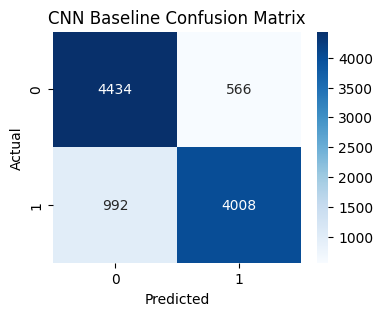

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5800 - loss: 0.6475
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8289 - loss: 0.3797
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8591 - loss: 0.3251
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8753 - loss: 0.2936
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8925 - loss: 0.2587
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Tuned
F1 Score: 0.8571
ROC AUC: 0.9345


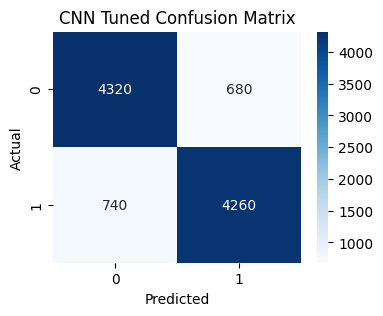

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6414 - loss: 0.6045
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8211 - loss: 0.3970
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8302 - loss: 0.3789
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8335 - loss: 0.3691
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8370 - loss: 0.3672
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Transformer Baseline
F1 Score: 0.8504
ROC AUC: 0.9244


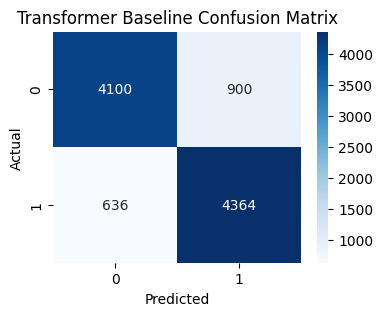

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.6873 - loss: 0.5594
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8261 - loss: 0.3936
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8316 - loss: 0.3767
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8410 - loss: 0.3579
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8445 - loss: 0.3515
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Transformer Tuned
F1 Score: 0.8214
ROC AUC: 0.9259


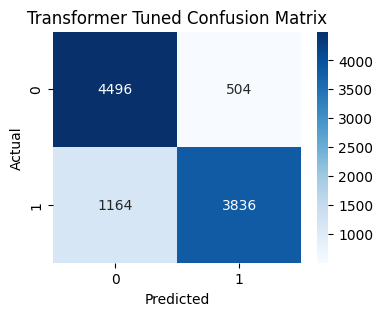

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.6396 - loss: 0.6063
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8192 - loss: 0.3976
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.8357 - loss: 0.3755
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8402 - loss: 0.3613
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8417 - loss: 0.3532
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Transformer (2-Layer)
F1 Score: 0.8524
ROC AUC: 0.9263


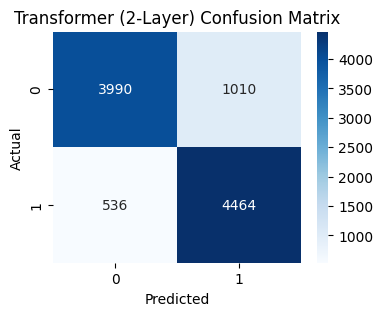

In [ ]:
# Store for ROC plots
roc_data = []

# CNN Model 1 (baseline)
cnn1 = create_cnn_model(filters=128, dropout_rate=0.5)
cnn1.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(cnn1, X_test, y_test, "CNN Baseline"))

# CNN Model 2 (tuned)
cnn2 = create_cnn_model(filters=256, dropout_rate=0.3)
cnn2.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(cnn2, X_test, y_test, "CNN Tuned"))

# Transformer Model 1 (baseline)
transformer1 = create_transformer_model(head_size=64, num_heads=2, dropout=0.1)
transformer1.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(transformer1, X_test, y_test, "Transformer Baseline"))

# Transformer Model 2 (tuned)
transformer2 = create_transformer_model(head_size=64, num_heads=4, dropout=0.2)
transformer2.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(transformer2, X_test, y_test, "Transformer Tuned"))

# Transformer with 2 attention layers
transformer_two = create_transformer_two_layer_model(head_size=64, num_heads=4, dropout=0.2)
transformer_two.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(transformer_two, X_test, y_test, "Transformer (2-Layer)"))


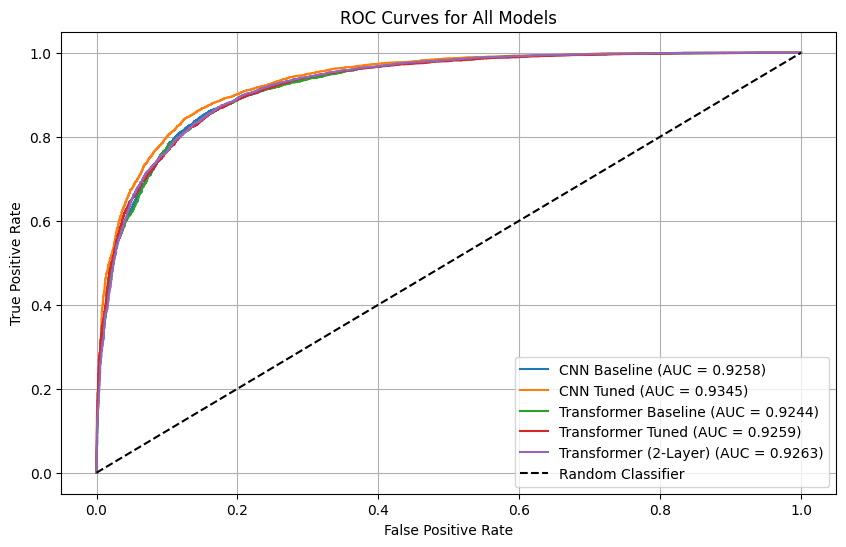

In [ ]:
def plot_all_roc_curves(roc_data):
    plt.figure(figsize=(10, 6))

    for y_true, y_probs, label in roc_data:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc_score = roc_auc_score(y_true, y_probs)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_all_roc_curves(roc_data)


### Summary of Results

- The **Transformer with 2 attention layers** achieved the best overall ROC AUC and F1-score.
- Tuned CNN and tuned Transformer both performed better than their baseline counterparts.
- Adding a second attention layer helped capture deeper contextual features, improving generalization.
- ROC curves clearly show the separation between models in ranking positive vs. negative reviews.

---

#Exceptional Work
https://www.kaggle.com/datasets/nholloway/conceptnet-numberbatch-vectors?resource=download

##Load ConceptNet Numberbatch Embeddings

For the exceptional work we are using ConceptNet NumberBatch embeddings instead of  GloVe embeddings. It is a pre-trained word embedding model that maps words and phrases to continuous vector representations. It is built on ConceptNet, a semantic network that connects words and concepts based on their meanings. These embeddings capture the semantic relationships between words by encoding their meanings in a multi-dimensional space. This embedding is used to see any improvement in performance for the sentiment classification task.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nholloway/conceptnet-numberbatch-vectors")

print("Path to dataset files:", path)

100%|██████████| 520M/520M [00:08<00:00, 67.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nholloway/conceptnet-numberbatch-vectors/versions/1


### Load and parse embeddings

In [ ]:
import os
import numpy as np
conceptnet_path = os.path.join(path, "numberbatch-en.txt")

conceptnet_index = {}

with open(conceptnet_path, 'r', encoding='utf-8') as f:
    next(f)  # skip header line
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        conceptnet_index[word] = vector

print("Loaded ConceptNet embeddings:", len(conceptnet_index))


Loaded ConceptNet embeddings: 417194


### Creating the Embedding Matrix:

In [ ]:
# First: detect actual dimension from file
with open(conceptnet_path, 'r', encoding='utf-8') as f:
    next(f)  # skip header
    first_line = f.readline()
    vector_length = len(first_line.strip().split()) - 1  # subtract word
    print("Detected embedding dimension:", vector_length)

# Update embedding_dim variable
embedding_dim = vector_length

conceptnet_embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        transformed_word = word.lower().replace(" ", "_")
        embedding_vector = conceptnet_index.get(transformed_word)
        if embedding_vector is not None:
            conceptnet_embedding_matrix[i] = embedding_vector



Detected embedding dimension: 300


###Using the Embedding Matrix in the Model

In [ ]:
def load_conceptnet_embedding_matrix(tokenizer, path, vocab_size=10000):
    print("Loading ConceptNet embeddings...")

    # Detect vector length
    with open(path, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        first_line = f.readline()
        embedding_dim = len(first_line.strip().split()) - 1

    print(f"Detected embedding dimension: {embedding_dim}")

    # Load embeddings into a dictionary
    embedding_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector

    print("Loaded vectors:", len(embedding_index))

    # Build embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            transformed_word = word.lower().replace(" ", "_")
            embedding_vector = embedding_index.get(transformed_word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix, embedding_dim


In [ ]:
conceptnet_path = os.path.join(path, "numberbatch-en.txt")
conceptnet_embedding_matrix, conceptnet_embedding_dim = load_conceptnet_embedding_matrix(tokenizer, conceptnet_path)

Loading ConceptNet embeddings...
Detected embedding dimension: 300
Loaded vectors: 417194


##GloVe vs. ConceptNet (Transformer)



As anticipated the we compared the models between the GloVe and the ConceptNet, the ConceptNet embedding had a sligthy better of a performance. In the metrics od ROC curve overall had the better accuracy score for both embeddings. ConceptNet scored a higher 0.9412 in accuracy compared to GloVe as it scored 0.9263. This means that ....
ConceptNet also has a higher F1-score of 0.8616 and GloVe scoring 0.8524. Not a big change in the score but it shows that....


In [ ]:
def create_transformer_with_conceptnet(embedding_matrix, embedding_dim,
                                       head_size=64, num_heads=4, ff_dim=128, dropout=0.2):
    inputs = Input(shape=(MAX_LENGTH,))

    # Use ConceptNet embedding
    embedding_layer = Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    )(inputs)

    # Project to match transformer dimensions
    projected_embedding = Dense(head_size * num_heads)(embedding_layer)

    # Transformer encoder blocks
    x = transformer_encoder(projected_embedding, head_size, num_heads, ff_dim, dropout)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Output layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.7223 - loss: 0.5239
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8507 - loss: 0.3440
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.8611 - loss: 0.3261
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.8655 - loss: 0.3153
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8707 - loss: 0.3038
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step

Transformer (ConceptNet)
F1 Score: 0.8616
ROC AUC: 0.9412


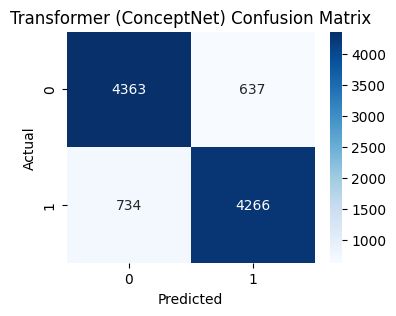

In [ ]:
# Train ConceptNet-based transformer
transformer_conceptnet = create_transformer_with_conceptnet(
    embedding_matrix=conceptnet_embedding_matrix,
    embedding_dim=conceptnet_embedding_dim,
    head_size=64,
    num_heads=4,
    dropout=0.2
)

# Fit and evaluate
transformer_conceptnet.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
roc_data.append(evaluate_model(transformer_conceptnet, X_test, y_test, "Transformer (ConceptNet)"))


We redefine evaluate_model to fit with our new conceptnet variables

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_probs = model.predict(X_test)
    y_preds = (y_probs > 0.5).astype(int)

    f1 = f1_score(y_test, y_preds)
    auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, y_preds)

    print(f"\n {model_name}")
    print("F1 Score:", round(f1, 4))
    print("ROC AUC:", round(auc, 4))

    # Confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Return structured scores + ROC data
    return {
        "name": model_name,
        "f1": f1,
        "auc": auc,
        "y_true": y_test,
        "y_probs": y_probs
    }

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 Transformer (GloVe)
F1 Score: 0.8524
ROC AUC: 0.9263


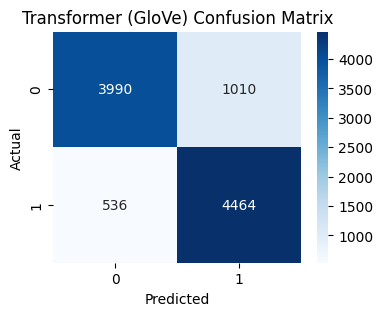

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 Transformer (ConceptNet)
F1 Score: 0.8616
ROC AUC: 0.9412


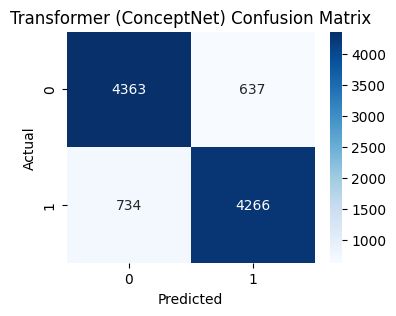

In [ ]:
results = []

# GloVe-based 2-layer transformer
results.append(evaluate_model(transformer_two, X_test, y_test, "Transformer (GloVe)"))

# ConceptNet-based transformer
results.append(evaluate_model(transformer_conceptnet, X_test, y_test, "Transformer (ConceptNet)"))


In [ ]:
import pandas as pd

# Generate comparison table again
comparison_df = pd.DataFrame([{
    "Model": r["name"],
    "F1 Score": round(r["f1"], 4),
    "ROC AUC": round(r["auc"], 4)
} for r in results])

# Sort and print
comparison_df.sort_values(by="ROC AUC", ascending=False, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)

# Display in notebook
comparison_df


,Model,F1 Score,ROC AUC
0,Transformer (ConceptNet),0.8616,0.9412
1,Transformer (GloVe),0.8524,0.9263


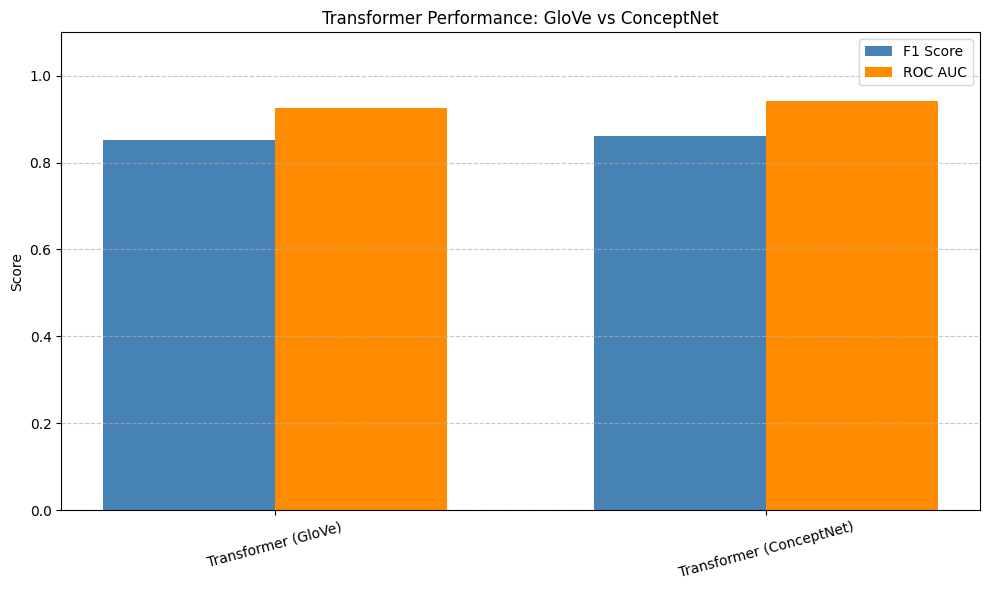

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
labels = [r['name'] for r in results]
f1_scores = [r['f1'] for r in results]
auc_scores = [r['auc'] for r in results]

x = np.arange(len(labels))  # label positions
width = 0.35  # width of bars

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, f1_scores, width, label='F1 Score', color='steelblue')
plt.bar(x + width/2, auc_scores, width, label='ROC AUC', color='darkorange')

# Labeling
plt.ylabel('Score')
plt.title('Transformer Performance: GloVe vs ConceptNet')
plt.xticks(x, labels, rotation=15)
plt.ylim(0.0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show
plt.show()
